In [1]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore pandas deprecation warning
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
from tqdm.auto import tqdm


In [2]:
class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

## Get data

In [3]:
from utils import BASE_PATH, SPEC_DIR

from utils import metadata_df, process_all_specs, create_spec_npy_dirs
# Run this to convert the spectrograms to .npy
if False:
    create_spec_npy_dirs()
    process_all_specs()
    
metadata = metadata_df("train")
metadata_test = metadata_df("test")
display(metadata.head(2))


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0


In [4]:
metadata_test

,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec_npy_path
0,853520,3911565283,6885,data/test_eegs/3911565283.parquet,data/test_spectrograms/853520.parquet,data/spectrograms_npy/test_spectrograms/853520...


## Visualize data

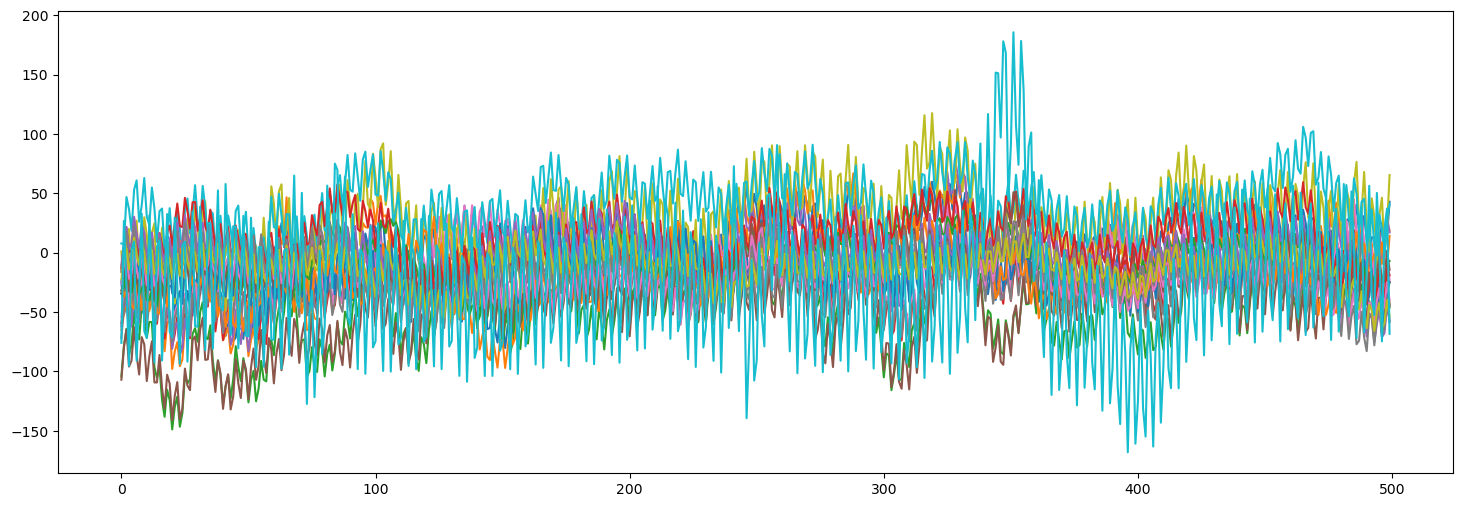

In [5]:
an_eeg = pd.read_parquet(metadata[metadata.expert_consensus == 'LPD'].iloc[0].eeg_path)
plt.figure(figsize=(18, 6))
plt.plot(an_eeg.iloc[:500]);

In [6]:
metadata.groupby("eeg_id").count()["eeg_sub_id"].value_counts()

eeg_sub_id
1      6324
2      1973
3      1430
4      1318
5       942
       ... 
101       1
85        1
236       1
210       1
226       1
Name: count, Length: 147, dtype: int64

In [7]:
idx = random.randint(0, len(metadata))
metadata.iloc[idx]

eeg_id                                                                      714492322
eeg_sub_id                                                                          9
eeg_label_offset_seconds                                                         64.0
spectrogram_id                                                              296993251
spectrogram_sub_id                                                                  9
spectrogram_label_offset_seconds                                                 64.0
label_id                                                                   2883738484
patient_id                                                                      20702
expert_consensus                                                              Seizure
seizure_vote                                                                        3
lpd_vote                                                                            0
gpd_vote                                              

In [8]:
spec_parquet = pd.read_parquet(metadata.iloc[idx].spec_path)
spec_parquet.shape

(357, 401)

In [9]:
spec_parquet.columns[101:201]

Index(['RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 'RL_1.56',
       'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34', 'RL_2.54', 'RL_2.73',
       'RL_2.93', 'RL_3.13', 'RL_3.32', 'RL_3.52', 'RL_3.71', 'RL_3.91',
       'RL_4.1', 'RL_4.3', 'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08',
       'RL_5.27', 'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25',
       'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 'RL_7.42',
       'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2', 'RL_8.4', 'RL_8.59',
       'RL_8.79', 'RL_8.98', 'RL_9.18', 'RL_9.38', 'RL_9.57', 'RL_9.77',
       'RL_9.96', 'RL_10.16', 'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94',
       'RL_11.13', 'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11',
       'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 'RL_13.28',
       'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06', 'RL_14.26', 'RL_14.45',
       'RL_14.65', 'RL_14.84', 'RL_15.04', 'RL_15.23', 'RL_15.43', 'RL_15.63',
       'RL_15.82', 'RL_16.02'

In [10]:
spec_parquet.tail()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
352,705,14.48,28.230000,28.600000,32.380001,24.65,13.71,9.53,4.99,4.20,...,0.04,0.03,0.03,0.03,0.02,0.02,0.01,0.03,0.05,0.07
353,707,18.51,23.469999,31.200001,24.969999,21.77,9.62,7.37,3.95,3.32,...,0.03,0.03,0.03,0.02,0.02,0.02,0.01,0.04,0.06,0.05
354,709,19.52,20.170000,24.520000,23.559999,13.71,8.26,5.81,3.71,4.25,...,0.01,0.02,0.02,0.02,0.01,0.01,0.01,0.03,0.05,0.05
355,711,6.84,9.140000,9.750000,8.450000,5.24,4.21,2.20,1.58,1.66,...,0.04,0.02,0.04,0.04,0.03,0.04,0.03,0.04,0.05,0.05
356,713,15.77,18.150000,21.410000,14.840000,10.10,10.29,7.42,6.25,6.14,...,0.04,0.05,0.03,0.03,0.04,0.03,0.03,0.03,0.04,0.04


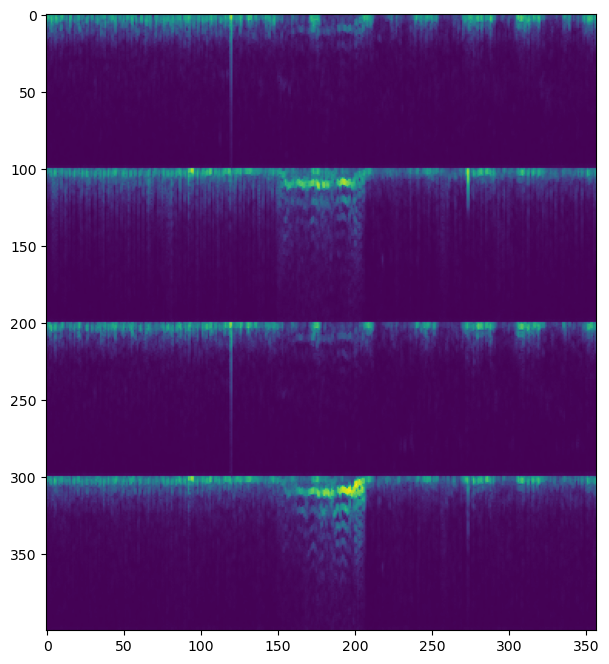

In [11]:
img = spec_parquet.iloc[:, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(8,8))
plt.imshow(img)

In [12]:
metadata[metadata.eeg_id == metadata.iloc[idx].eeg_id]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
14866,714492322,0,0.0,296993251,0,0.0,825972105,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14867,714492322,1,4.0,296993251,1,4.0,2531176735,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14868,714492322,2,6.0,296993251,2,6.0,3247621370,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14869,714492322,3,10.0,296993251,3,10.0,4132091963,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14870,714492322,4,26.0,296993251,4,26.0,1334516565,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14871,714492322,5,30.0,296993251,5,30.0,964521134,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14872,714492322,6,34.0,296993251,6,34.0,3473303071,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14873,714492322,7,42.0,296993251,7,42.0,2587401453,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14874,714492322,8,52.0,296993251,8,52.0,1361259365,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0
14875,714492322,9,64.0,296993251,9,64.0,2883738484,20702,Seizure,3,0,0,0,0,0,data/train_eegs/714492322.parquet,data/train_spectrograms/296993251.parquet,data/spectrograms_npy/train_spectrograms/29699...,0


Note from the "time" column that the spectrogram data samples are spaced 2 seconds apart, starting at t=1. In other words, the parquet row is related to `time` by `time == 2*row + 1`. (I haven't checked this for every spectrogram!)

Each spectrogram item in the dataset is a 600-second window from the given file, starting at the even integer `spectrogram_label_offset_seconds`. In other words, the item consists of rows `[x/2:x/2+300]`, where `x=spectrogram_label_offset_seconds`.

For a better explanation that also includes the EEGs, see [this Kaggle post](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010).

Time offset: 64.0 s


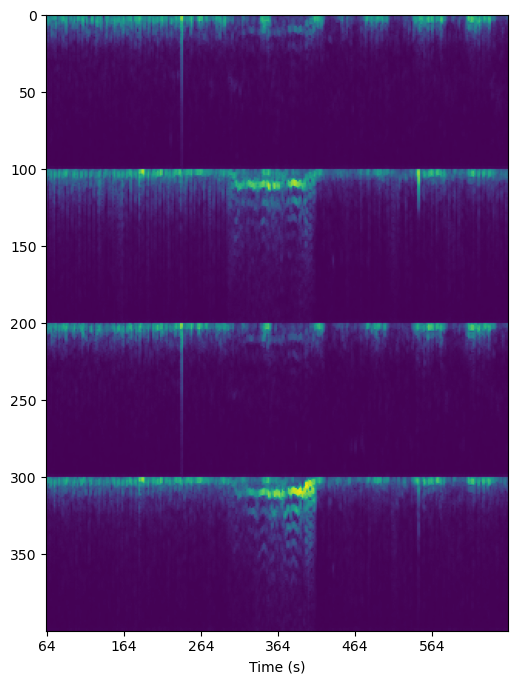

In [13]:
# Image of a single data item
x = metadata.iloc[idx].eeg_label_offset_seconds
print(f"Time offset: {x} s")
x = int(x)
img = spec_parquet.iloc[x//2:x//2+300, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.xticks(np.arange(0, 300, 50), np.arange(x, x+600, 100));
plt.xlabel("Time (s)");

## Define validation set

I'm going to use this to evaluate performance before submitting to Kaggle. Cross-validation should also be used.

Since the dataset includes groups of multiple items taken from the same underlying spectrogram, we have to take care that the validation set consists of entirely different spectrograms than the training set -- otherwise, the validation score might be biased.

In [14]:
valid_frac = 0.1
num_unique_spectrograms = metadata.spectrogram_id.unique().shape[0]
valid_num = round(valid_frac * num_unique_spectrograms)
print(f"{num_unique_spectrograms} unique spectrograms, using {valid_num} for validation set.")
rng = np.random.default_rng(seed=4)
valid_set = rng.choice(metadata.spectrogram_id.unique(), size=valid_num, replace=False)
metadata_train = metadata[~metadata.spectrogram_id.isin(valid_set)]
metadata_valid = metadata[metadata.spectrogram_id.isin(valid_set)]
print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")


11138 unique spectrograms, using 1114 for validation set.
95346 training items, 11454 validation items.


## Define dataset and dataloader

In [15]:
from utils import SpectrogramDataset, SpectrogramTestDataset
train = SpectrogramDataset(metadata_train)
valid = SpectrogramDataset(metadata_valid)
test = SpectrogramTestDataset(metadata_test)
print(f"{len(train)} training items, {len(valid)} validation items, {len(test)} testing item.")

95346 training items, 11454 validation items, 1 testing item.


In [16]:
train[0]

(tensor([[ 4.2600,  2.6500,  4.1800,  ...,  1.8700,  3.2700,  4.1800],
         [10.9800,  3.9700,  4.5300,  ...,  3.5900,  5.6300,  5.8500],
         [ 9.0500, 12.1800,  8.7700,  ...,  8.6900,  9.4600,  7.2200],
         ...,
         [ 0.1600,  0.3100,  0.4800,  ...,  0.1000,  0.0800,  0.2500],
         [ 0.2200,  0.3600,  0.4400,  ...,  0.1000,  0.1300,  0.1700],
         [ 0.1900,  0.4000,  0.4800,  ...,  0.1000,  0.1400,  0.1500]]),
 tensor([3., 0., 0., 0., 0., 0.]))

In [17]:
test[0]

(tensor([[14.9100, 11.1300, 10.8800,  ...,  9.6100,  8.4300, 12.3300],
         [17.1100, 10.9500, 10.5700,  ..., 13.3200, 11.8400, 11.8400],
         [11.6600, 10.7700,  8.7900,  ...,  9.1900, 13.6400,  9.4200],
         ...,
         [ 0.0500,  0.0300,  0.0500,  ...,  0.3900,  0.4500,  0.4600],
         [ 0.0400,  0.0300,  0.0600,  ...,  0.5600,  0.4500,  0.5400],
         [ 0.0500,  0.0200,  0.0600,  ...,  0.2900,  0.3400,  0.2900]]),
 None)

In [18]:
train[0][0].shape

torch.Size([400, 300])

In a moment I'll plug this data into a vision model trained on color images. This model expects tensors of shape `[batch_size, 3, height, width]` (3 for RGB). The simplest way to encode grayscale images in this format is to send a grayscale pixel with value `x` to an RGB pixel with value `[x, x, x]`. It's easy to do this on batches, so I'll have the model do it -- this is slightly faster than doing it item-by-item on the dataset.

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, 32)
valid_loader = DataLoader(valid, 32)
train_iter = iter(train_loader)
train_batch = next(train_iter)
train_batch_2 = next(train_iter)
valid_batch = next(iter(valid_loader))
print(train_batch[0].shape, train_batch[1].shape)
print(train_batch_2[0].shape, train_batch_2[1].shape)
print(valid_batch[0].shape, valid_batch[1].shape)

torch.Size([32, 400, 300]) torch.Size([32, 6])
torch.Size([32, 400, 300]) torch.Size([32, 6])
torch.Size([32, 400, 300]) torch.Size([32, 6])


## Define metric and model

In [20]:
# Also in torch
from torch.nn import KLDivLoss
loss_fn = KLDivLoss(reduction="batchmean")
# See kl_divergence.ipynb for a comparison of this with similar functions
targ = torch.tensor([3, 0, 0, 0, 0, 0], dtype=torch.float)
dists = [
    torch.tensor([2/3, 1/3, 0, 0, 0, 0], dtype=torch.float),
    torch.tensor([1, 0, 0, 0, 0, 0], dtype=torch.float),
    torch.tensor([0.75, 0.25, 0, 0.25, 0, 0], dtype=torch.float),
    torch.tensor([0, 1, 0, 0, 0, 0], dtype=torch.float),
]
for dist in dists:
    logprob = torch.log(dist.clip(0.001, 0.999))
    loss = loss_fn(logprob, targ)
    print("Distribution:", dist.numpy())
    print("Approximate log probability:", logprob.numpy())
    print("Target:", targ.numpy())
    print(f"KL divergence {loss:.3f}.")
    print()


Distribution: [0.6666667  0.33333334 0.         0.         0.         0.        ]
Approximate log probability: [-0.40546507 -1.0986123  -6.9077554  -6.9077554  -6.9077554  -6.9077554 ]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 0.752.

Distribution: [1. 0. 0. 0. 0. 0.]
Approximate log probability: [-1.0004875e-03 -6.9077554e+00 -6.9077554e+00 -6.9077554e+00
 -6.9077554e+00 -6.9077554e+00]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 0.550.

Distribution: [0.75 0.25 0.   0.25 0.   0.  ]
Approximate log probability: [-0.28768206 -1.3862944  -6.9077554  -1.3862944  -6.9077554  -6.9077554 ]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 0.693.

Distribution: [0. 1. 0. 0. 0. 0.]
Approximate log probability: [-6.9077554e+00 -1.0004875e-03 -6.9077554e+00 -6.9077554e+00
 -6.9077554e+00 -6.9077554e+00]
Target: [3. 0. 0. 0. 0. 0.]
KL divergence 4.003.



## Build and train model

In [28]:
import utils
reload(utils)
import utils.models
reload(utils.models)
from utils.models import Spectrogram_EfficientNet
from torchinfo import summary

train = SpectrogramDataset(metadata_train)
valid = SpectrogramDataset(metadata_valid)
test = SpectrogramTestDataset(metadata_test)
train_loader = DataLoader(train, 32, shuffle=True)
valid_loader = DataLoader(valid, 32)
model = Spectrogram_EfficientNet()

summary(model, col_names=["input_size", "output_size", "trainable"],
        col_width=20,
        depth=4,
        row_settings=["depth", "var_names"],
        input_data=train_batch[0])

Layer (type (var_name):depth-idx)                                      Input Shape          Output Shape         Trainable
Spectrogram_EfficientNet (Spectrogram_EfficientNet)                    [32, 400, 300]       [32, 6]              Partial
├─EfficientNet (efficientnet): 1-1                                     [32, 3, 400, 300]    [32, 6]              Partial
│    └─Sequential (features): 2-1                                      [32, 3, 400, 300]    [32, 1280, 13, 10]   False
│    │    └─Conv2dNormActivation (0): 3-1                              [32, 3, 400, 300]    [32, 32, 200, 150]   False
│    │    │    └─Conv2d (0): 4-1                                       [32, 3, 400, 300]    [32, 32, 200, 150]   False
│    │    │    └─BatchNorm2d (1): 4-2                                  [32, 32, 200, 150]   [32, 32, 200, 150]   False
│    │    │    └─SiLU (2): 4-3                                         [32, 32, 200, 150]   [32, 32, 200, 150]   --
│    │    └─Sequential (1): 3-2            

In [29]:
from utils import DEVICE
print(DEVICE)
model.to(DEVICE);

cuda


In [30]:
from utils import Trainer
trainer = Trainer(model, train_loader, valid_loader,
                  criterion=KLDivLoss(reduction="batchmean"), lr=0.1)

trainer.train_eval_loop(len(train_loader), 1000, 500)

Training:   0%|          | 0/4770 [00:00<?, ?it/s]

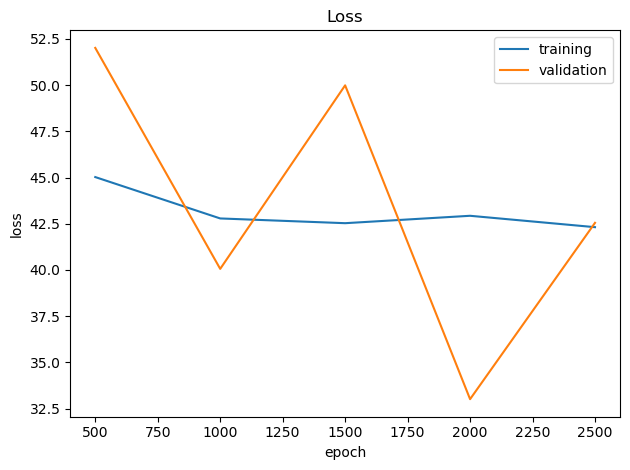

In [31]:
trainer.plot_metrics()

In [41]:
# Test predicting on a batch
loss_fn = KLDivLoss(reduction="batchmean")
model.eval()
with torch.inference_mode():
    a_batch = next(iter(train_loader))
    preds = model(a_batch[0].to(DEVICE)).cpu()
preds_df = pd.DataFrame(preds.exp().numpy(), columns=[x + ": Predicted" for x in class_names])
true_df = pd.DataFrame(a_batch[1].numpy(), columns=[x + ": Actual" for x in class_names])
col_order = sum(([x + ": Predicted", x + ": Actual"] for x in class_names), [])
all_df = pd.concat([preds_df, true_df], axis=1)[col_order]
all_df


,Seizure: Predicted,Seizure: Actual,LPD: Predicted,LPD: Actual,GPD: Predicted,GPD: Actual,LRDA: Predicted,LRDA: Actual,GRDA: Predicted,GRDA: Actual,Other: Predicted,Other: Actual
0,2.755317e-04,0.0,0.817392,3.0,5.779114e-03,0.0,1.852172e-02,0.0,5.616059e-02,0.0,0.101871,0.0
1,6.476020e-09,1.0,0.001628,11.0,6.603821e-06,0.0,9.723841e-10,0.0,7.607931e-07,0.0,0.998364,2.0
2,7.287659e-09,0.0,0.001684,0.0,6.794469e-06,0.0,1.152358e-09,0.0,8.250742e-07,0.0,0.998308,2.0
3,8.009732e-09,0.0,0.001057,4.0,7.168660e-06,10.0,3.068591e-10,0.0,2.052668e-07,0.0,0.998936,0.0
4,7.322423e-09,3.0,0.001675,0.0,6.873275e-06,0.0,1.153709e-09,0.0,8.291025e-07,0.0,0.998317,0.0
5,7.108366e-09,0.0,0.001663,13.0,6.807434e-06,0.0,1.101614e-09,0.0,8.036673e-07,0.0,0.998330,0.0
6,2.764811e-10,3.0,0.000241,0.0,1.224827e-06,0.0,5.643092e-12,0.0,4.782932e-08,0.0,0.999757,0.0
7,7.130922e-09,0.0,0.000580,0.0,4.197239e-06,0.0,2.414383e-10,0.0,4.316737e-07,0.0,0.999415,12.0
8,8.728235e-11,0.0,0.000262,0.0,1.724726e-07,0.0,2.326657e-12,0.0,4.338307e-10,0.0,0.999738,18.0
9,5.386204e-09,0.0,0.002545,0.0,6.948819e-06,0.0,1.051919e-09,0.0,1.020407e-06,3.0,0.997447,0.0


## Can I load the entire dataset into memory?

In [44]:
len(metadata_train.spectrogram_id.unique())

10024

In [52]:
# Do any spectrogram IDs correspond to multiple paths?
(metadata_train.groupby("spectrogram_id")["spec_npy_path"].nunique() != 1).sum()

0

In [53]:
# Vice versa?
(metadata_train.groupby("spec_npy_path")["spectrogram_id"].nunique() != 1).sum()

0

In [58]:
metadata_train.spec_npy_path.unique()

array(['data/spectrograms_npy/train_spectrograms/353733.npy',
       'data/spectrograms_npy/train_spectrograms/924234.npy',
       'data/spectrograms_npy/train_spectrograms/999431.npy', ...,
       'data/spectrograms_npy/train_spectrograms/2146798838.npy',
       'data/spectrograms_npy/train_spectrograms/2147312808.npy',
       'data/spectrograms_npy/train_spectrograms/2147388374.npy'],
      dtype=object)

In [87]:
class SpectrogramDatasetPreloaded(torch.utils.data.Dataset):
    def __init__(self, metadata_df, item_transforms=None):
        self.metadata_df = metadata_df
        self.item_transforms = item_transforms
        # load all data
        self.spec_dict = {npy_path: torch.from_numpy(np.load(npy_path))
                          for npy_path in metadata_df.spec_npy_path.unique()}
        
    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, i):
        npy_path = self.metadata_df["spec_npy_path"].iloc[i]
        offset = int(self.metadata_df["spectrogram_label_offset_seconds"].iloc[i])
        tens = self.spec_dict[npy_path][:, offset//2:offset//2+300]
        if self.item_transforms is not None:
            tens = self.item_transforms(tens)
        expert_votes = self.metadata_df[[
            "seizure_vote", "lpd_vote", "gpd_vote",
            "lrda_vote", "grda_vote", "other_vote"
        ]].iloc[i]
        # target should be float so that nn.KLDivLoss works
        target = torch.tensor(np.asarray(expert_votes)).float()
        return tens, target

In [88]:
train_preloaded = SpectrogramDatasetPreloaded(metadata_train)

In [100]:
import sys
num_specs = len(metadata_train.spec_npy_path.unique())
print("Number of spectrograms:", num_specs)
a_key = random.choice(metadata_train.spec_npy_path.unique())
arr_size = train_preloaded.spec_dict[a_key].element_size() * train_preloaded.spec_dict[a_key].nelement()
print(f"A random spectrogram uses {arr_size // 1024} kB, for an estimated total of {num_specs * arr_size / (1024 ** 3):.2f} GB.")

Number of spectrograms: 10024
A random spectrogram uses 468 kB, for an estimated total of 4.48 GB.


In [101]:
train_loader_preloaded = DataLoader(train_preloaded, 32, shuffle=True)
valid_preloaded = SpectrogramDatasetPreloaded(metadata_valid)
valid_loader_preloaded = DataLoader(valid_preloaded, 32)
trainer_preloaded = Trainer(model, train_loader_preloaded, valid_loader_preloaded,
                            criterion=KLDivLoss(reduction="batchmean"), lr=0.1)
print("Without preloading:")
trainer.time_train_step(1000)
trainer.time_val_step(1000)
print("With preloading:")
trainer_preloaded.time_train_step(1000)
trainer_preloaded.time_val_step(1000)

Without preloading:
Trained on 1000 batches in 71.79s.
Predicted on 1000 validation batches in 54.97s.
With preloading:
Trained on 1000 batches in 62.29s.
Predicted on 1000 validation batches in 49.31s.


1000